In [1]:
import pandas as pd
import os  
import warnings

warnings.filterwarnings('ignore')

In [2]:
pwd = os.getcwd()

In [3]:
shapelets = [[0.70629,  1.20629,  2.29629, 3.29329,  0, 0.20224496,  1.20224496, 11.20224496, 21.20224496, 10.60214496]]

In [4]:
pwd

'x:\\Datasets\\Blockchain\\xblock.pro\\eth-phishing-detection'

In [5]:
import numpy as np
# 提取时序交易信息

len_timeseries = 50

X_timeseries = pd.DataFrame()
indexs = []
labels = []
timeseries = []

# 提取钓鱼信息
for filename in os.listdir(pwd + '/original_data/open/钓鱼一阶节点'):
    if filename.endswith('.csv'):
        data = pd.read_csv(pwd + '/original_data/open/钓鱼一阶节点/' + filename)
        # 当From为filname的时候，Value为负值
        data.loc[data['From'] == filename.split('.')[0], 'Value'] = -data['Value']
        # 每次交易后的余额
        data['Balance'] = data['Value'].cumsum()
        # 提取Value
        values = data['Balance'].values
        timeseries.append(values)

        # 对齐数据，使得每个文件的数据长度相同
        if len(values) < len_timeseries:
            values = np.pad(values, (0, len_timeseries - len(values)), 'constant')
        else:
            values = values[:len_timeseries]

        # 最后一列为label
        
        X_timeseries = X_timeseries.append(pd.DataFrame(values).T)
        indexs.append(filename.split('.')[0])
        labels.append(0)

# 提取正常交易信息
for filename in os.listdir(pwd + '/original_data/open/非钓鱼一阶节点'):
    if filename.endswith('.csv'):
        data = pd.read_csv(pwd + '/original_data/open/非钓鱼一阶节点/' + filename)
        # 当From为filname的时候，Value为负值
        data.loc[data['From'] == filename.split('.')[0], 'Value'] = -data['Value']
        # 每次交易后的余额
        data['Balance'] = data['Value'].cumsum()
        # 提取Value
        values = data['Balance'].values
        timeseries.append(values)

        # 对齐数据，使得每个文件的数据长度相同
        if len(values) < len_timeseries:
            # values = np.pad(values, (0, len_timeseries - len(values)), 'constant')
            # 设置为最后一个值
            values = np.pad(values, (0, len_timeseries - len(values)), 'edge')
        else:
            values = values[:len_timeseries]
        
        X_timeseries = X_timeseries.append(pd.DataFrame(values).T)
        indexs.append(filename.split('.')[0])
        labels.append(1)

# 最后一列的列名为label
X_timeseries['label'] = labels
X_timeseries['address'] = indexs
X_timeseries.fillna(0, inplace=True)


In [6]:
X_timeseries.index = [i for i in range(X_timeseries.shape[0])]

In [7]:
# address放到第一列
cols = X_timeseries.columns.tolist()
cols = cols[-1:] + cols[:-1]
X_timeseries = X_timeseries[cols]

In [8]:
X_timeseries.head()

,address,0,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,label
0,0x002bf459dc58584d58886169ea0e80f3ca95ffaf,0.586269,0.000861,0.948376,0.001092,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.500000,0.501020,0.000630,0.818430,0.000924,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,0.450017,0.457393,0.556801,0.563723,0.568270,0.570575,0.574259,0.588520,0.595542,...,3.986715,3.98932,3.991305,3.999379,4.002653,4.027329,4.227329,4.234658,4.239549,0
3,0x0061fb5485dff4bb85c078dca80d19119224d97e,0.500000,1.000000,1.500000,2.000000,2.589139,3.089139,3.189139,2.189139,2.190139,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,0x00650a784ee109797ba8c05f3496bdbf2b2b7a1c,0.680000,0.004000,0.000700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [14]:
# 计算motifs与其他样本之间的dtw

from pyts.metrics import dtw

data = pd.DataFrame()
data['label'] = X_timeseries['label']

index = 0
# 计算motifs与其他样本之间的dtw
for motif in shapelets:
    distance = []
    # print(X_timeseries.shape[0])
    for i in range(X_timeseries.shape[0]):
        # sample_timeseries = list(X_timeseries[i])
        sample_timeseries = X_timeseries.iloc[i, 1:-1].values
    
        if len(sample_timeseries) < 2:
            sample_timeseries.append(sample_timeseries[-1])
        distance.append(dtw(motif, sample_timeseries))
    
    distance = pd.DataFrame(np.array(distance).reshape(-1, 1))
    
    distance.columns = ['motif_' + str(index)]
    
    data = pd.concat([data, distance], axis=1)

    index += 1
    

In [15]:
# 训练集和测试集

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data['label'], test_size=0.2, random_state=0)

# 训练模型
import xgboost as xgb

xgb_model = xgb.XGBClassifier()

xgb_model.fit(X_train, y_train)

# 预测
y_pred = xgb_model.predict(X_test)

# 评估
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       338
           1       0.96      0.95      0.96       334

    accuracy                           0.96       672
   macro avg       0.96      0.96      0.96       672
weighted avg       0.96      0.96      0.96       672



In [16]:
# 测试集
window_size = 10
window_sizes = range(10, 20)

# 滑动窗口截取测试集内容

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

result_windows_all = {}
result_timeseries_all = []

for window_size in window_sizes:
    result_windows = []
    result_timeseries = []  
    for i in range(X_test.shape[0]):
        # sample_timeseries = list(X_timeseries.drop(['label', 'address'], axis=1).iloc[i])
        sample_timeseries = list(timeseries[i])
        if len(sample_timeseries) < 50:
            continue
        # 滑动窗口
        result = []
        for j in range(len(sample_timeseries) - window_size + 1):
            sample = sample_timeseries[j: j + window_size]
            # 计算motifs与其他样本之间的dtw
            for motif in shapelets:
                distance = dtw(motif, sample)
                distance = pd.DataFrame(np.array(distance).reshape(-1, 1))
                distance.columns = ['motif_' + str(0)]
                # 使用xgboost进行预测
                y_pred = xgb_model.predict(distance)
                y_score = xgb_model.predict_proba(distance)
                result.append(y_score[0][1])

        # print(len(result))
        result_windows.append(result)
        result_timeseries.append(sample_timeseries)
    result_windows_all['window_size_' + str(window_size)] = result_windows
    result_timeseries_all = result_timeseries

In [ ]:
print(len(result_windows))

115


label: 1


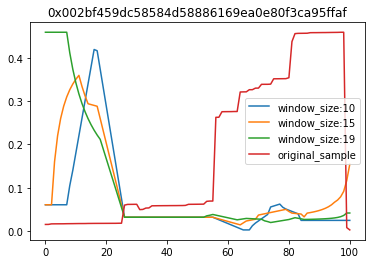

label: 1


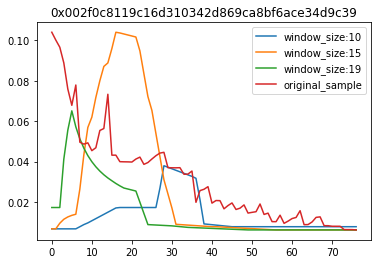

label: 1


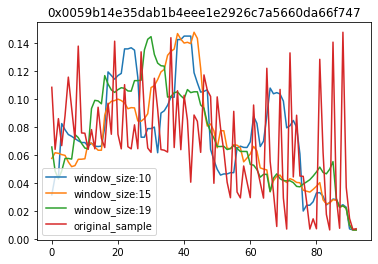

label: 0


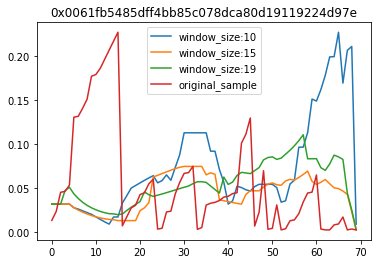

label: 0


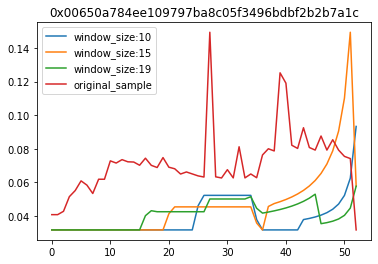

label: 0


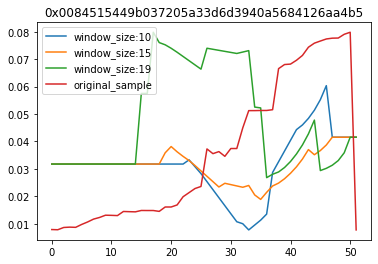

label: 1


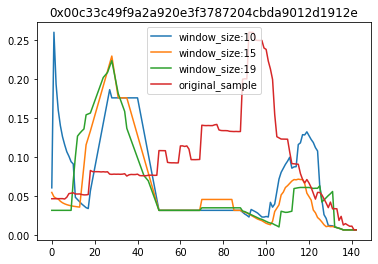

label: 0


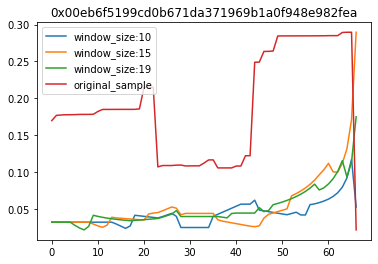

label: 0


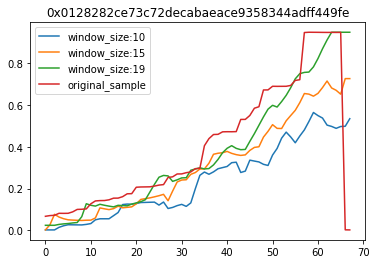

label: 0


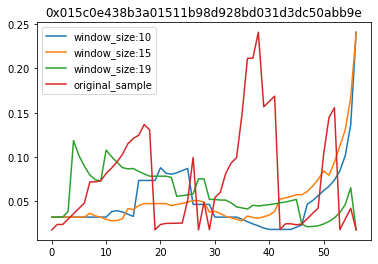

label: 0


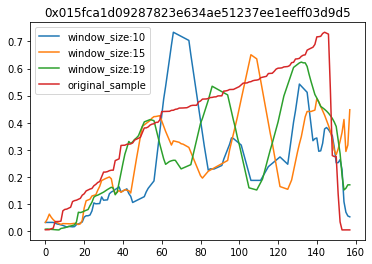

label: 1


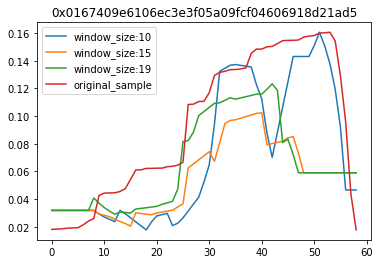

label: 0


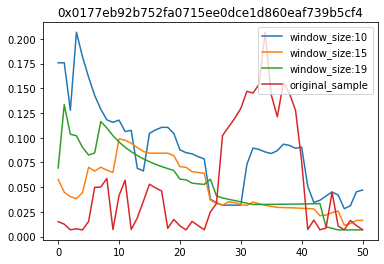

label: 0


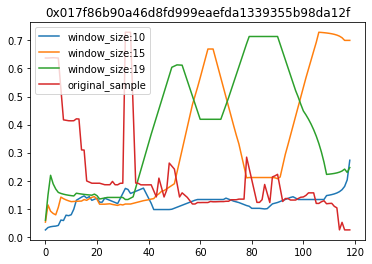

label: 0


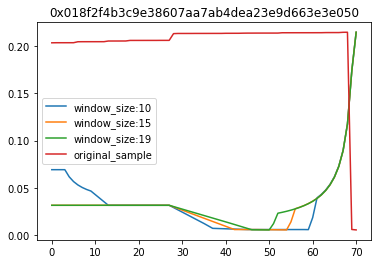

label: 0


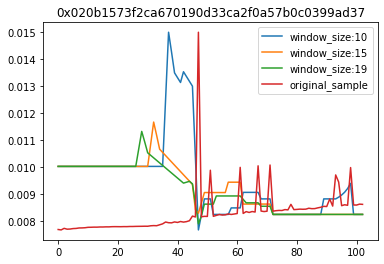

label: 0


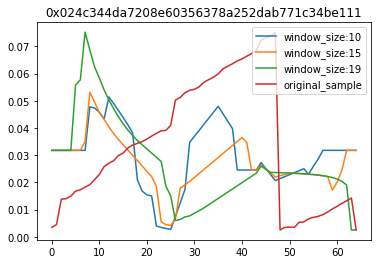

label: 1


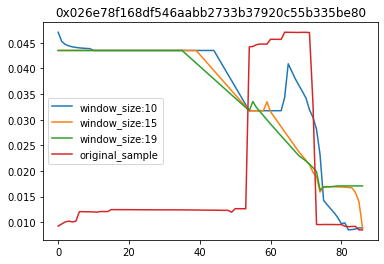

label: 0


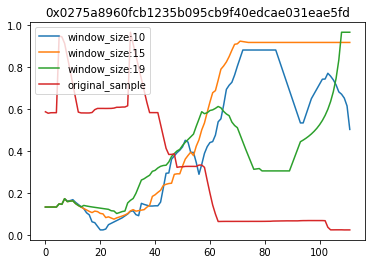

label: 0


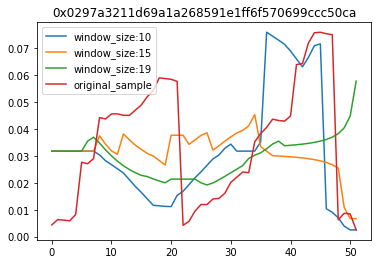

label: 0


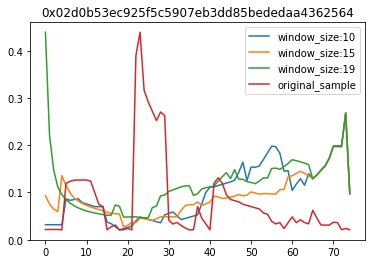

label: 1


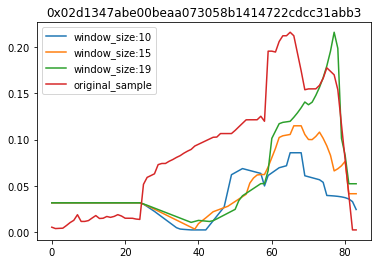

label: 1


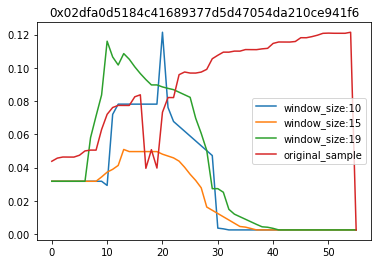

label: 0


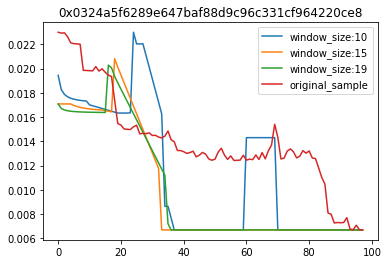

label: 1


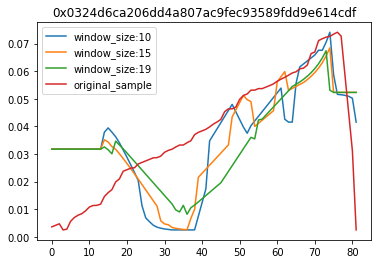

label: 1


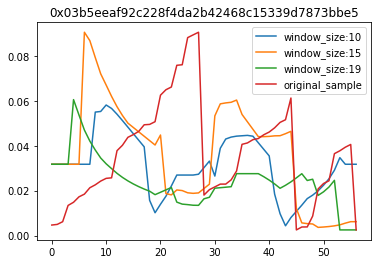

label: 1


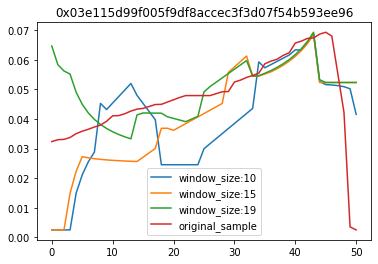

label: 1


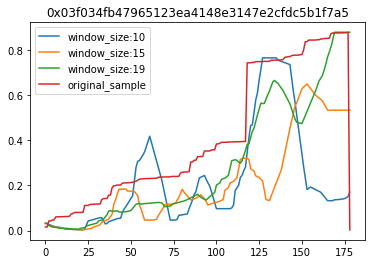

label: 1


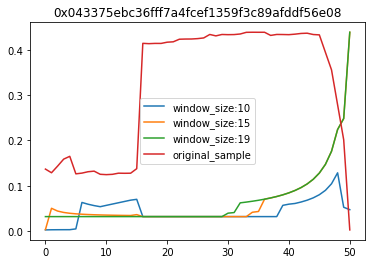

label: 1


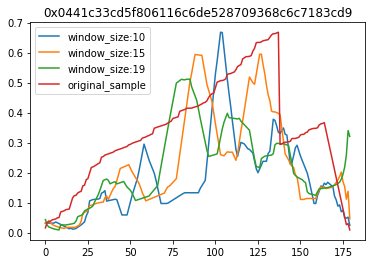

label: 0


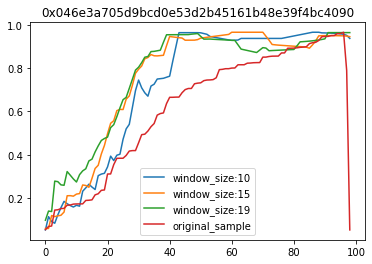

label: 1


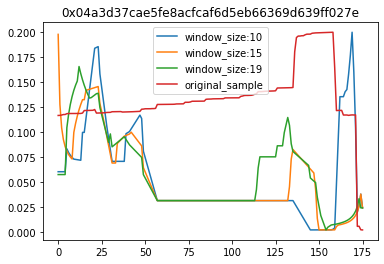

label: 1


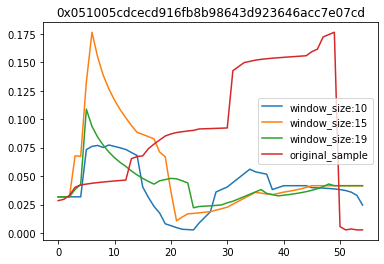

label: 1


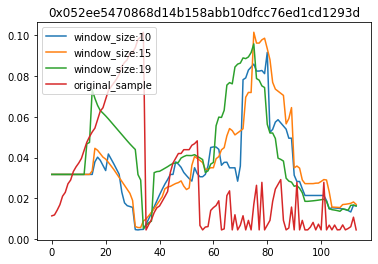

label: 1


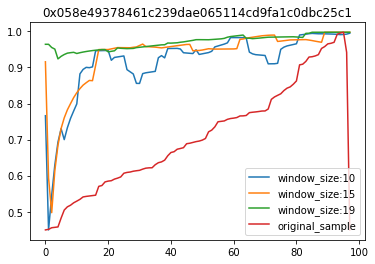

label: 0


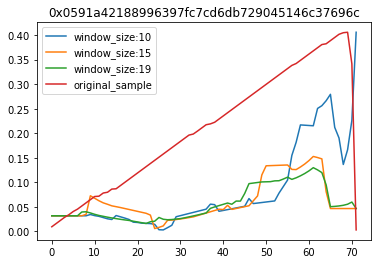

label: 1


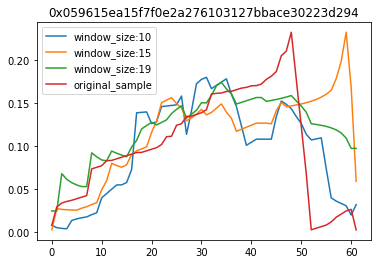

label: 0


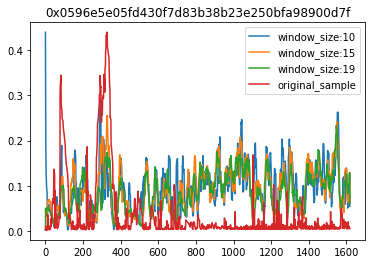

label: 0


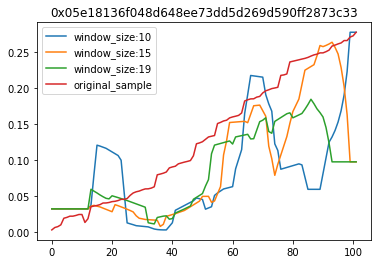

label: 1


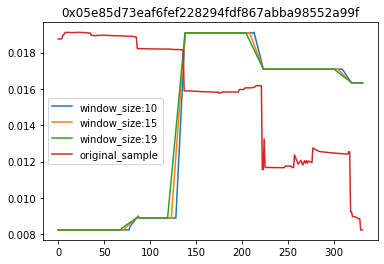

In [25]:
# 画10个图
import matplotlib.pyplot as plt

window_sizes = [10, 15, 19]

for i in range(40):
    plot_data = pd.DataFrame()
    origin_sample = []
    result_max = 0
    result_min = 0x3f3f3f3f
    for window_size in window_sizes:
        sample_window = result_windows_all['window_size_' + str(window_size)][i]
        sample_timeseries = result_timeseries_all[i]

        result = [0] * (len(sample_timeseries))
        count = [0] * (len(sample_timeseries))
        # 按照窗口大小进行扩展
        for j in range(len(sample_window)):
            for k in range(window_size):
                result[j + k] += sample_window[j]
                count[j + k] += 1

        # 计算平均值
        for j in range(len(result)):
            if count[j] != 0:
                result[j] = result[j] / count[j]
        
        result_max = max(max(result), result_max)
        result_min = min(min(result), result_min)
        
        plot_data['window_size:' + str(window_size)] = result
    
    origin_sample = result_timeseries[i]
    # 归一化到result_max和result_min之间
    origin_sample = [(i - min(origin_sample)) / (max(origin_sample) - min(origin_sample)) * (result_max - result_min) + result_min for i in origin_sample]
    plot_data['original_sample'] = origin_sample

    plot_data.plot()
    plt.title(X_timeseries['address'][i])
    # address
    print('label: ' + str(y_test[i]))
    plt.legend()
    plt.show()